In [7]:
import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from linearmodels.datasets import wage_panel

%matplotlib inline
pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

# Panel Data
What would happen if we had more periods? Or more groups? Turns out this setup is so common and powerful for causal inference that it gets its own name: panel data. A panel is when we have repeated observations of the same unit over multiple periods of time. This happens a lot in government policy evaluation, where we can track data on multiple cities or states over multiple years. But it is also incredibly common in the industry, where companies track user data over multiple weeks and months.

## Controlling What you Cannot See
Methods like propensity score, linear regression and matching are very good at controlling for confounding in non-random data, but they rely on a key assumption: conditional unconfoundedness. To put it in words, they require that all the confounders are known and measured, so that we can condition on them and make the treatment as good as random. One major issue with this is that sometimes we simply can't measure a confounder.

This puts us in a difficult situation, because if we have unmeasured confounders, we have bias. One way to deal with this is with instrumental variables, as we've seen before. But coming up with good instruments it's no easy task and requires a lot of creativity. Here, instead let's take advantage of our panel data structure.

## Fixed Effects
To make matters more formal, let's first take a look at the data that we have. Following our example, we will try to estimate the effect of marriage on income. Our data contains those 2 variables, married and lwage, on multiple individuals (nr) for multiple years. Notice that wage is in log form. In addition to this, we have other controls, like number of hours worked that year, years of education and so on.

In [8]:
data = wage_panel.load()
data.head()

,nr,year,black,...,lwage,expersq,occupation
0,13,1980,0,...,1.197540,1,9
1,13,1981,0,...,1.853060,4,9
2,13,1982,0,...,1.344462,9,9
3,13,1983,0,...,1.433213,16,9
4,13,1984,0,...,1.568125,25,5


In [9]:
mod = smf.ols("lwage ~ C(year)", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.3935,0.022,63.462,0.000,1.350,1.437
C(year)[T.1981],0.1194,0.031,3.845,0.000,0.059,0.180
C(year)[T.1982],0.1782,0.031,5.738,0.000,0.117,0.239
C(year)[T.1983],0.2258,0.031,7.271,0.000,0.165,0.287
C(year)[T.1984],0.2968,0.031,9.558,0.000,0.236,0.358
C(year)[T.1985],0.3459,0.031,11.140,0.000,0.285,0.407
C(year)[T.1986],0.4062,0.031,13.082,0.000,0.345,0.467
C(year)[T.1987],0.4730,0.031,15.232,0.000,0.412,0.534


Notice how this model is predicting the average income in 1980 to be 1.3935, in 1981 to be 1.5129 (1.3935+0.1194) and so on. Now, if we compute the average by year, we get the exact same result. (Remember that the base year, 1980, is the intercept. So you have to add the intercept to the parameters of the other years to get the mean lwage for the year).

In [10]:
data.groupby("year")["lwage"].mean()

year
1980    1.393477
1981    1.512867
1982    1.571667
1983    1.619263
1984    1.690295
1985    1.739410
1986    1.799719
1987    1.866479
Name: lwage, dtype: float64

This means that if we get the average for every person in our panel, we are essentially regressing the individual dummy on the other variables.
To check which variables are those, we can group our data by individual and get the sum of the standard deviations. If it is zero, it means the variable isn't changing across time for any of the individuals.

In [11]:
data.groupby("nr").std().sum()

year            1334.971910
black              0.000000
exper           1334.971910
hisp               0.000000
hours         203098.215649
married          140.372801
educ               0.000000
union            106.512445
lwage            173.929670
expersq        17608.242825
occupation       739.222281
dtype: float64

For our data, we need to remove entinicity dummies, black and hisp, since they are constant for the individual. Also, we need to remove education. We will also not use occupation, since this is probably mediating the effect of marriage on wage (it could be that single men are able to take more time demanding positions). Having selected the features we will use, it's time to estimate this model.

To run our fixed effect model, first, let's get our mean data. We can achieve this by grouping everything by individuals and taking the mean.

In [12]:
Y = 'lwage'
T = 'married'
X = [T, 'expersq', 'union', 'hours']

mean_data = data.groupby('nr')[X+[Y]].mean()
mean_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.000,25.5,0.125,2807.625,1.255652
17,0.000,61.5,0.000,2504.125,1.637786
18,1.000,61.5,0.000,2350.500,2.034387
45,0.125,35.5,0.250,2225.875,1.773664
110,0.500,77.5,0.125,2108.000,2.055129


In [13]:
demeaned_data = (data.set_index("nr")[X+[Y]] - mean_data) # subtract the mean data
demeaned_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.0,-24.5,-0.125,-135.625,-0.058112
13,0.0,-21.5,0.875,-487.625,0.597408
13,0.0,-16.5,-0.125,132.375,0.088810
13,0.0,-9.5,-0.125,152.375,0.177561
13,0.0,-0.5,-0.125,263.375,0.312473


In [15]:
mod = smf.ols(f"{Y} ~ {'+'.join(X)}", data=demeaned_data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-6.852e-17,0.005,-1.35e-14,1.000,-0.010,0.010
married,0.1147,0.017,6.756,0.000,0.081,0.148
expersq,0.0040,0.000,21.958,0.000,0.004,0.004
union,0.0784,0.018,4.261,0.000,0.042,0.115
hours,-8.46e-05,1.25e-05,-6.744,0.000,-0.000,-6e-05


If we believe that fixed effect eliminates the all omitted variable bias, this model is telling us that marriage increases a man's wage by 11%. This result is very significant. One detail here is that for fixed effect models, the standard errors need to be clustered. So, instead of doing all our estimation by hand (which is only nice for pedagogical reasons), we can use the library linearmodels and set the argument cluster_entity to True.

In [16]:
from linearmodels.panel import PanelOLS


mod = PanelOLS.from_formula('lwage ~ expersq + union + married + hours + EntityEffects', data=data.set_index(['nr', 'year']))
result = mod.fit(cov_type='clustered', cluster_entity=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,0.0040,0.0002,16.552,0.0000,0.0035,0.0044
hours,-8.46e-05,2.22e-05,-3.8105,0.0001,-0.0001,-4.107e-05
married,0.1147,0.0220,5.2213,0.0000,0.0716,0.1577
union,0.0784,0.0236,3.3225,0.0009,0.0322,0.1247


Notice how the parameter estimates are identical to the ones we've got with time-demeaned data. The only difference is that the standard errors are a bit larger. Now, compare this to the simple OLS model that doesn't take the time structure of the data into account. For this model, we add back the variables that are constant in time.

In [17]:
mod = smf.ols('lwage ~ expersq + union + married + hours + black + hisp + educ', data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2654,0.065,4.103,0.000,0.139,0.392
expersq,0.0032,0.000,15.750,0.000,0.003,0.004
union,0.1829,0.017,10.598,0.000,0.149,0.217
married,0.1410,0.016,8.931,0.000,0.110,0.172
hours,-5.32e-05,1.34e-05,-3.978,0.000,-7.94e-05,-2.7e-05
black,-0.1347,0.024,-5.679,0.000,-0.181,-0.088
hisp,0.0132,0.021,0.632,0.528,-0.028,0.054
educ,0.1057,0.005,22.550,0.000,0.097,0.115


This model is saying that marriage increases the man's wage by 14%. A somewhat larger effect than the one we found with the fixed effect model. This suggests some omitted variable bias due to fixed individual factors, like intelligence and beauty, not being added to the model.

# Visualizing Fixed Effects

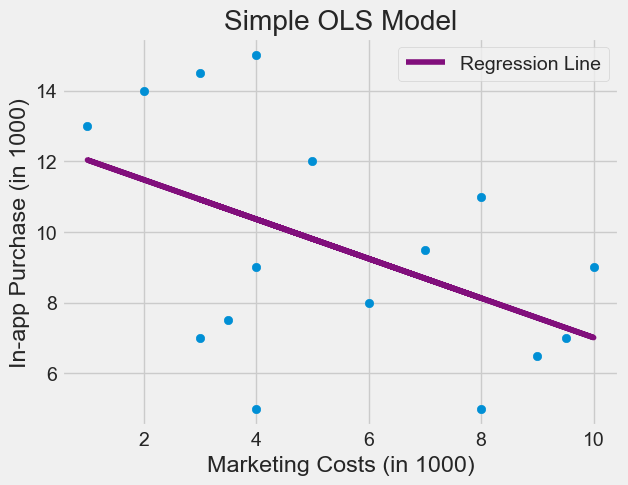

In [18]:
toy_panel = pd.DataFrame({
    'mkt_costs': [5, 4, 3.5, 3, 10, 9.5, 9, 8, 4, 3, 2, 1, 8, 7, 6, 4],
    'purchase': [12, 9, 7.5, 7, 9, 7, 6.5, 5, 15, 14.5, 14, 13, 11, 9.5, 8, 5],
    'city': ['C0', 'C0', 'C0', 'C0', 'C2', 'C2', 'C2', 'C2', 'C1', 'C1', 'C1', 'C1', 'C3', 'C3', 'C3', 'C3']
})

m = smf.ols('purchase ~ mkt_costs', data=toy_panel).fit()

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase)
plt.plot(toy_panel.mkt_costs, m.fittedvalues, c='C5', label='Regression Line')
plt.xlabel('Marketing Costs (in 1000)')
plt.ylabel('In-app Purchase (in 1000)')
plt.title('Simple OLS Model')
plt.legend()

Knowing a lot about causal inference, you decide to run a fixed effect model, adding the city's indicator as a dummy variable to your model. The fixed effect model controls for city specific characteristics that are constant in time, so if a city is less open to your product, it will capture that. When you run that model, you can finally see that more marketing costs leads to higher in-app purchase.

Text(0, 0.5, 'In-app Purchase (in 1000)')

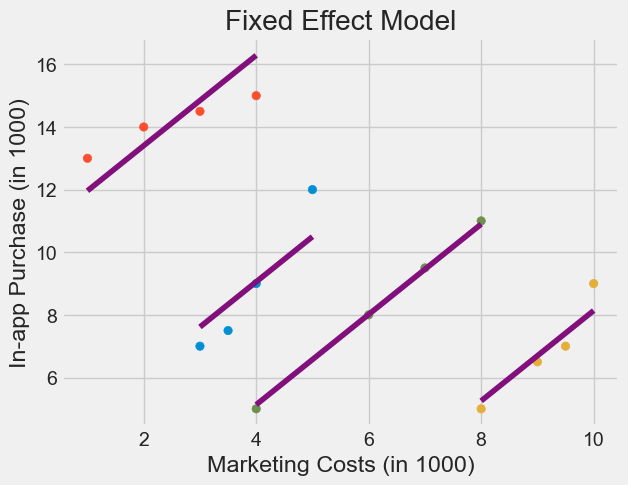

In [19]:
fe = smf.ols('purchase ~ mkt_costs + C(city)', data=toy_panel).fit()
fe_toy = toy_panel.assign(y_hat = fe.fittedvalues)

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase, c=toy_panel.city)
for city in fe_toy['city'].unique():
    plot_df = fe_toy.query(f'city == "{city}"')
    plt.plot(plot_df.mkt_costs, plot_df.y_hat, c='C5')

plt.title('Fixed Effect Model')
plt.xlabel('Marketing Costs (in 1000)')
plt.ylabel('In-app Purchase (in 1000)')

# Time Effects

In [20]:
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects+TimeEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,-0.0062,0.0008,-8.1479,0.0000,-0.0077,-0.0047
hours,-0.0001,3.546e-05,-3.8258,0.0001,-0.0002,-6.614e-05
married,0.0476,0.0177,2.6906,0.0072,0.0129,0.0823
union,0.0727,0.0228,3.1858,0.0015,0.0279,0.1174


Using panel data and fixed effects models is an extremely powerful tool for causal inference. When you don't have random data nor good instruments, the fixed effect is as convincing as it gets for causal inference with non experimental data. Still, it is worth mentioning that it is not a panacea. There are situations where even panel data won't help you.

The most obvious one is when you have confounders that are changing in time. Fixed effects can only eliminate bias from attributes that are constant for each individual. For instance, suppose that you can increase your intelligence level by reading books and eating lots of good fats. This causes you to get a higher paying job and a wife. Fixed effect won't be able to remove this bias due to unmeasured intelligence confounding because, in this example, intelligence is changing in time.